In [1]:
import re
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_score,
    recall_score
)


In [2]:
import pandas as pd
from pathlib import Path

# point to your copies inside the repo
TRAIN = Path("data/train_cleaned (2).csv")
TEST  = Path("data/test_cleaned (2).csv")

train_df = pd.read_csv(TRAIN)
test_df  = pd.read_csv(TEST)

print("train:", train_df.shape, "test:", test_df.shape)
train_df.head()



train: (159564, 8) test: (153114, 2)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww he matches this background colour im seem...,0,0,0,0,0,0
2,000113f07ec002fd,hey man im really not trying to edit war its j...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i cant make any real suggestions on impro...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


In [4]:
# option 2: alias to df
df = train_df
df.info()
print("\nMissing ratio:")
print(df.isna().mean().sort_values(ascending=False))



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159564 entries, 0 to 159563
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159564 non-null  object
 1   comment_text   159564 non-null  object
 2   toxic          159564 non-null  int64 
 3   severe_toxic   159564 non-null  int64 
 4   obscene        159564 non-null  int64 
 5   threat         159564 non-null  int64 
 6   insult         159564 non-null  int64 
 7   identity_hate  159564 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB

Missing ratio:
id               0.0
comment_text     0.0
toxic            0.0
severe_toxic     0.0
obscene          0.0
threat           0.0
insult           0.0
identity_hate    0.0
dtype: float64


In [5]:
import re
import pandas as pd

# 1) make binary label: toxic if ANY of 6 columns is 1
tox_cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
df['label'] = (df[tox_cols].sum(axis=1) > 0).astype(int)

# 2) simple cleaner
def clean_text(s):
    s = str(s).lower()
    s = re.sub(r"http\S+|www\.\S+", " url ", s)
    s = re.sub(r"[@#]\w+", " tag ", s)
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df['clean_text'] = df['comment_text'].astype(str).apply(clean_text)

# optional: check class balance
print(df['label'].value_counts(normalize=True))


label
0    0.898317
1    0.101683
Name: proportion, dtype: float64


/var/folders/7h/lzh4x0997y7gxlzss951wtsc0000gn/T/ipykernel_16346/364459780.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='Set2')


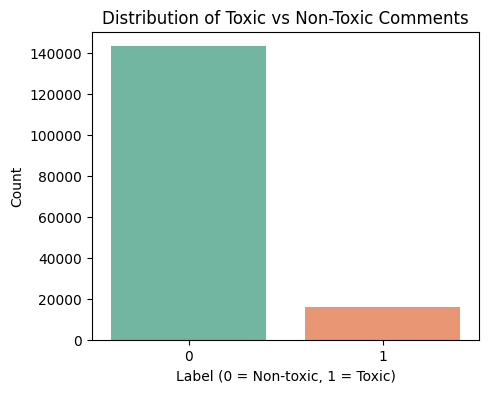

In [6]:
# show dataset imbalance (majority of comments are non-toxic)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,4))
sns.countplot(x='label', data=df, palette='Set2')
plt.title('Distribution of Toxic vs Non-Toxic Comments')
plt.xlabel('Label (0 = Non-toxic, 1 = Toxic)')
plt.ylabel('Count')
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

X = df[['clean_text']]   # use cleaned text
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


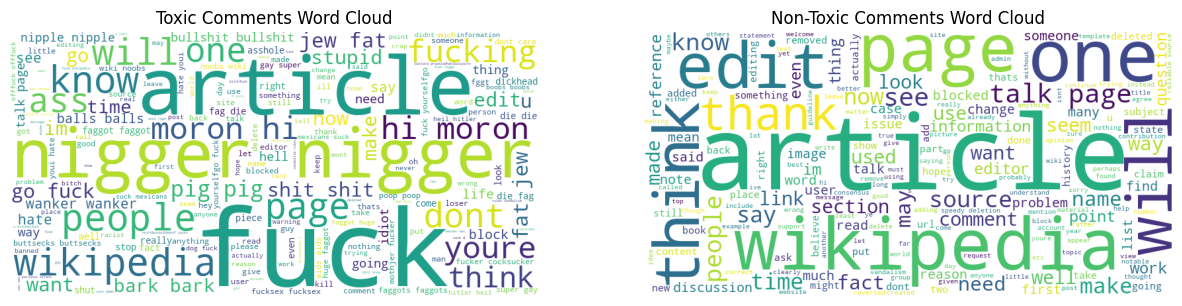

In [9]:
# see common words in each class in a word cloud
from wordcloud import WordCloud

toxic_text = " ".join(df.loc[df.label==1, 'clean_text'])
nontoxic_text = " ".join(df.loc[df.label==0, 'clean_text'])

fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].imshow(WordCloud(width=800, height=400, background_color='white').generate(toxic_text))
ax[0].set_title('Toxic Comments Word Cloud')
ax[0].axis('off')

ax[1].imshow(WordCloud(width=800, height=400, background_color='white').generate(nontoxic_text))
ax[1].set_title('Non-Toxic Comments Word Cloud')
ax[1].axis('off')

plt.show()

In [10]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# word-level TF-IDF
word_tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    stop_words='english'
)

# char-level TF-IDF
char_tfidf = TfidfVectorizer(
    analyzer='char',
    ngram_range=(3, 5),
    min_df=5
)

combined_tfidf = FeatureUnion([
    ('word', word_tfidf),
    ('char', char_tfidf)
])

clf_pipe = Pipeline([
    ('tfidf', combined_tfidf),
    ('logreg', LogisticRegression(
        max_iter=700,
        class_weight='balanced'
    ))
])

# fit baseline model
clf_pipe.fit(X_train['clean_text'], y_train)


,steps,"[('tfidf', ...), ('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformer_list,"[('word', ...), ('char', ...)]"
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,input,'content'
,encoding,'utf-8'


In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import FeatureUnion

# reuse same feature builders
word_tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    stop_words='english'
)
char_tfidf = TfidfVectorizer(
    analyzer='char',
    ngram_range=(3, 5),
    min_df=5
)
combined_tfidf = FeatureUnion([
    ('word', word_tfidf),
    ('char', char_tfidf)
])

pipe = Pipeline([
    ('tfidf', combined_tfidf),
    ('logreg', LogisticRegression(max_iter=700, class_weight='balanced'))
])

param_grid = {
    'logreg__C': [0.5, 1.0, 2.0]
}

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=3,
    n_jobs=-1,
    scoring='f1'
)

grid.fit(X_train['clean_text'], y_train)

best_model = grid.best_estimator_
print("Best params:", grid.best_params_)


Best params: {'logreg__C': 2.0}


In [12]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

proba = best_model.predict_proba(X_test['clean_text'])[:, 1]
y_pred = (proba >= 0.5).astype(int)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, proba))


              precision    recall  f1-score   support

           0       0.98      0.97      0.97     28668
           1       0.74      0.85      0.79      3245

    accuracy                           0.95     31913
   macro avg       0.86      0.91      0.88     31913
weighted avg       0.96      0.95      0.96     31913

[[27705   963]
 [  479  2766]]
ROC-AUC: 0.9792263881516529


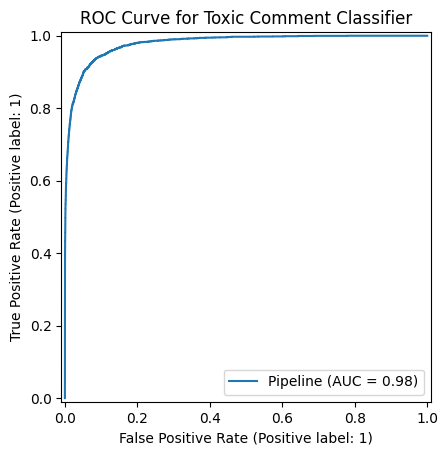

In [13]:
# ROC curve
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(best_model, X_test['clean_text'], y_test)
plt.title('ROC Curve for Toxic Comment Classifier')
plt.show()


In [14]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

proba = best_model.predict_proba(X_test['clean_text'])[:, 1]

best = None
for thr in np.arange(0.5, 0.71, 0.01):
    y_thr = (proba >= thr).astype(int)
    prec = precision_score(y_test, y_thr)
    rec  = recall_score(y_test, y_thr)
    # target: recall at least 0.80, then maximize precision
    if rec >= 0.80:
        if (best is None) or (prec > best['precision']):
            best = {
                'threshold': float(thr),
                'precision': float(prec),
                'recall': float(rec)
            }

print("Best tradeoff ≥0.80 recall:", best)


Best tradeoff ≥0.80 recall: {'threshold': 0.6600000000000001, 'precision': 0.8250396196513471, 'recall': 0.8021571648690293}


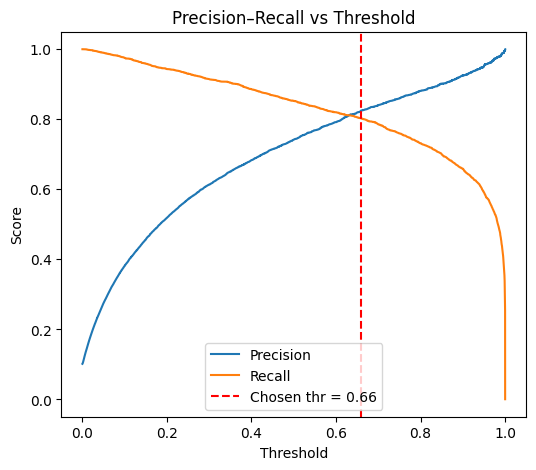

In [15]:
# threshld tuning visualization
from sklearn.metrics import precision_recall_curve

prec, rec, thr = precision_recall_curve(y_test, proba)
plt.figure(figsize=(6,5))
plt.plot(thr, prec[:-1], label='Precision')
plt.plot(thr, rec[:-1], label='Recall')
plt.axvline(best['threshold'], color='red', linestyle='--', label=f"Chosen thr = {best['threshold']:.2f}")
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision–Recall vs Threshold')
plt.legend()
plt.show()


In [16]:
from sklearn.metrics import classification_report, confusion_matrix

FINAL_THRESHOLD = best['threshold']

proba = best_model.predict_proba(X_test['clean_text'])[:, 1]
y_final = (proba >= FINAL_THRESHOLD).astype(int)

print(f"Final threshold: {FINAL_THRESHOLD}")
print(classification_report(y_test, y_final))
print(confusion_matrix(y_test, y_final))


Final threshold: 0.6600000000000001
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     28668
           1       0.83      0.80      0.81      3245

    accuracy                           0.96     31913
   macro avg       0.90      0.89      0.90     31913
weighted avg       0.96      0.96      0.96     31913

[[28116   552]
 [  642  2603]]


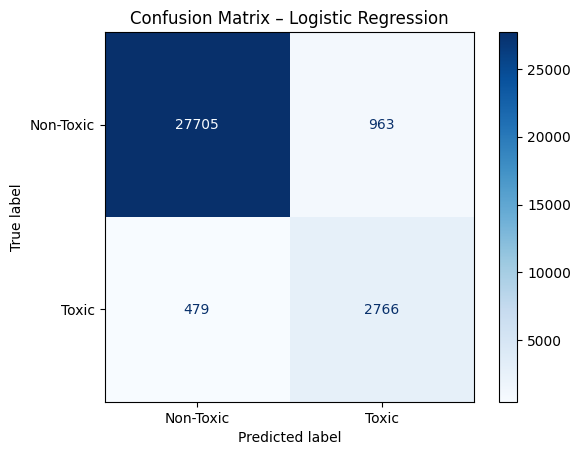

In [17]:
# true vs predicted classes heatmap
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    best_model,
    X_test['clean_text'], y_test,
    display_labels=['Non-Toxic','Toxic'],
    cmap='Blues'
)
plt.title('Confusion Matrix – Logistic Regression')
plt.show()


In [18]:
import joblib

joblib.dump(best_model, 'toxic_logreg_char_word.joblib')
print("Saved model. Use threshold:", FINAL_THRESHOLD)


Saved model. Use threshold: 0.6600000000000001


In [19]:
import re

def clean_text(s):
    s = str(s).lower()
    s = re.sub(r"http\S+|www\.\S+", " url ", s)
    s = re.sub(r"[@#]\w+", " tag ", s)
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s


In [20]:
def predict_toxic(texts):
    # texts: list of strings
    cleaned = [clean_text(t) for t in texts]
    probs = best_model.predict_proba(cleaned)[:, 1]
    preds = (probs >= FINAL_THRESHOLD).astype(int)
    return preds, probs

# try it
samples = [
    "you are pretty stupid",
    "you are a bad motherfucker",
    "my friend will will kill you with a pen",
    "that is sticky"
]

preds, probs = predict_toxic(samples)

for text, p, pr in zip(samples, preds, probs):
    print(f"text: {text}")
    print(f"predicted label: {p}  (1 = toxic, 0 = not toxic)")
    print(f"probability toxic: {pr:.3f}")
    print("-" * 40)


text: you are pretty stupid
predicted label: 1  (1 = toxic, 0 = not toxic)
probability toxic: 1.000
----------------------------------------
text: you are a bad motherfucker
predicted label: 1  (1 = toxic, 0 = not toxic)
probability toxic: 1.000
----------------------------------------
text: my friend will will kill you with a pen
predicted label: 1  (1 = toxic, 0 = not toxic)
probability toxic: 0.931
----------------------------------------
text: that is sticky
predicted label: 0  (1 = toxic, 0 = not toxic)
probability toxic: 0.136
----------------------------------------


In [21]:
import joblib
from pathlib import Path

models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

joblib.dump(best_model, models_dir / "toxic_logreg_cv.joblib")


['models/toxic_logreg_cv.joblib']